# Extract data
## Introduction
This notebook scrapes `procyclingstats.com` and extracts professional cyclists' data for a season. This is done with the aim to eventually predict a successful fantasy team. Cleaning of the data will be done as well. Feature creation and analysis will be done in the next notebooks.

We extract all the data for riders at stage 1 of the tour. Thereafter we itterate through each rider's profile on `procyclingstats.com` and scrape the races that they have partaken in, for the season. Thereafter, we itterate through all the races and extract their profiles (diificulty, uci status). The data is saved. 

In [1]:
# imports
import pandas as pd
import requests
from bs4 import BeautifulSoup
import numpy as np
import re
import os
from importlib import reload
import stage
import stageConstants

In [2]:
CREATE_DATA = False
# the first stage of the race
RACE = 'tour-de-france'
YEAR = 2020
STAGE = 1
URL1 = 'https://www.procyclingstats.com/race/{}/{}/stage-{}/result/result'.format(RACE, YEAR, STAGE)

folder_loc = './temp_data/{}'.format(RACE)
if not os.path.exists(folder_loc):
    os.mkdir(folder_loc)
folder_loc = '{}/{}'.format(folder_loc, YEAR)
if not os.path.exists(folder_loc):
    os.mkdir(folder_loc)
    
# saved data locations
FIRST_STAGE_LOC = '{}/first.csv'.format(folder_loc)
RACES_LOC = '{}/races_df.csv'.format(folder_loc)
STAGES_LOC = '{}/stages_df.csv'.format(folder_loc)
NEW_STAGES_LOC = '{}/new_stages_df.csv'.format(folder_loc)
RIDERS_LOC = '{}/riders_df.csv'.format(folder_loc)
ALL_RACE_DATA = '{}/ALL_RACE_DATA.csv'.format(folder_loc)
TEAMS_HISTORY_LOC = '{}/teams_history.csv'.format(folder_loc)

race_page = requests.get(URL1)
race_html = BeautifulSoup(race_page.content, 'html.parser')

def reload_libraries():
    reload(stageConstants)
    reload(stage)
    print('Reloaded')

## Scrape data for stage one
Below we scrape the html page for the first stage of a tour. We itterate through the data cells in the html page and append them, appropriately to a row. Each row belongs to a dataset. There can be up to 6 datasets on a page. 

The screenshot of the website below shows the 6 datasets. 

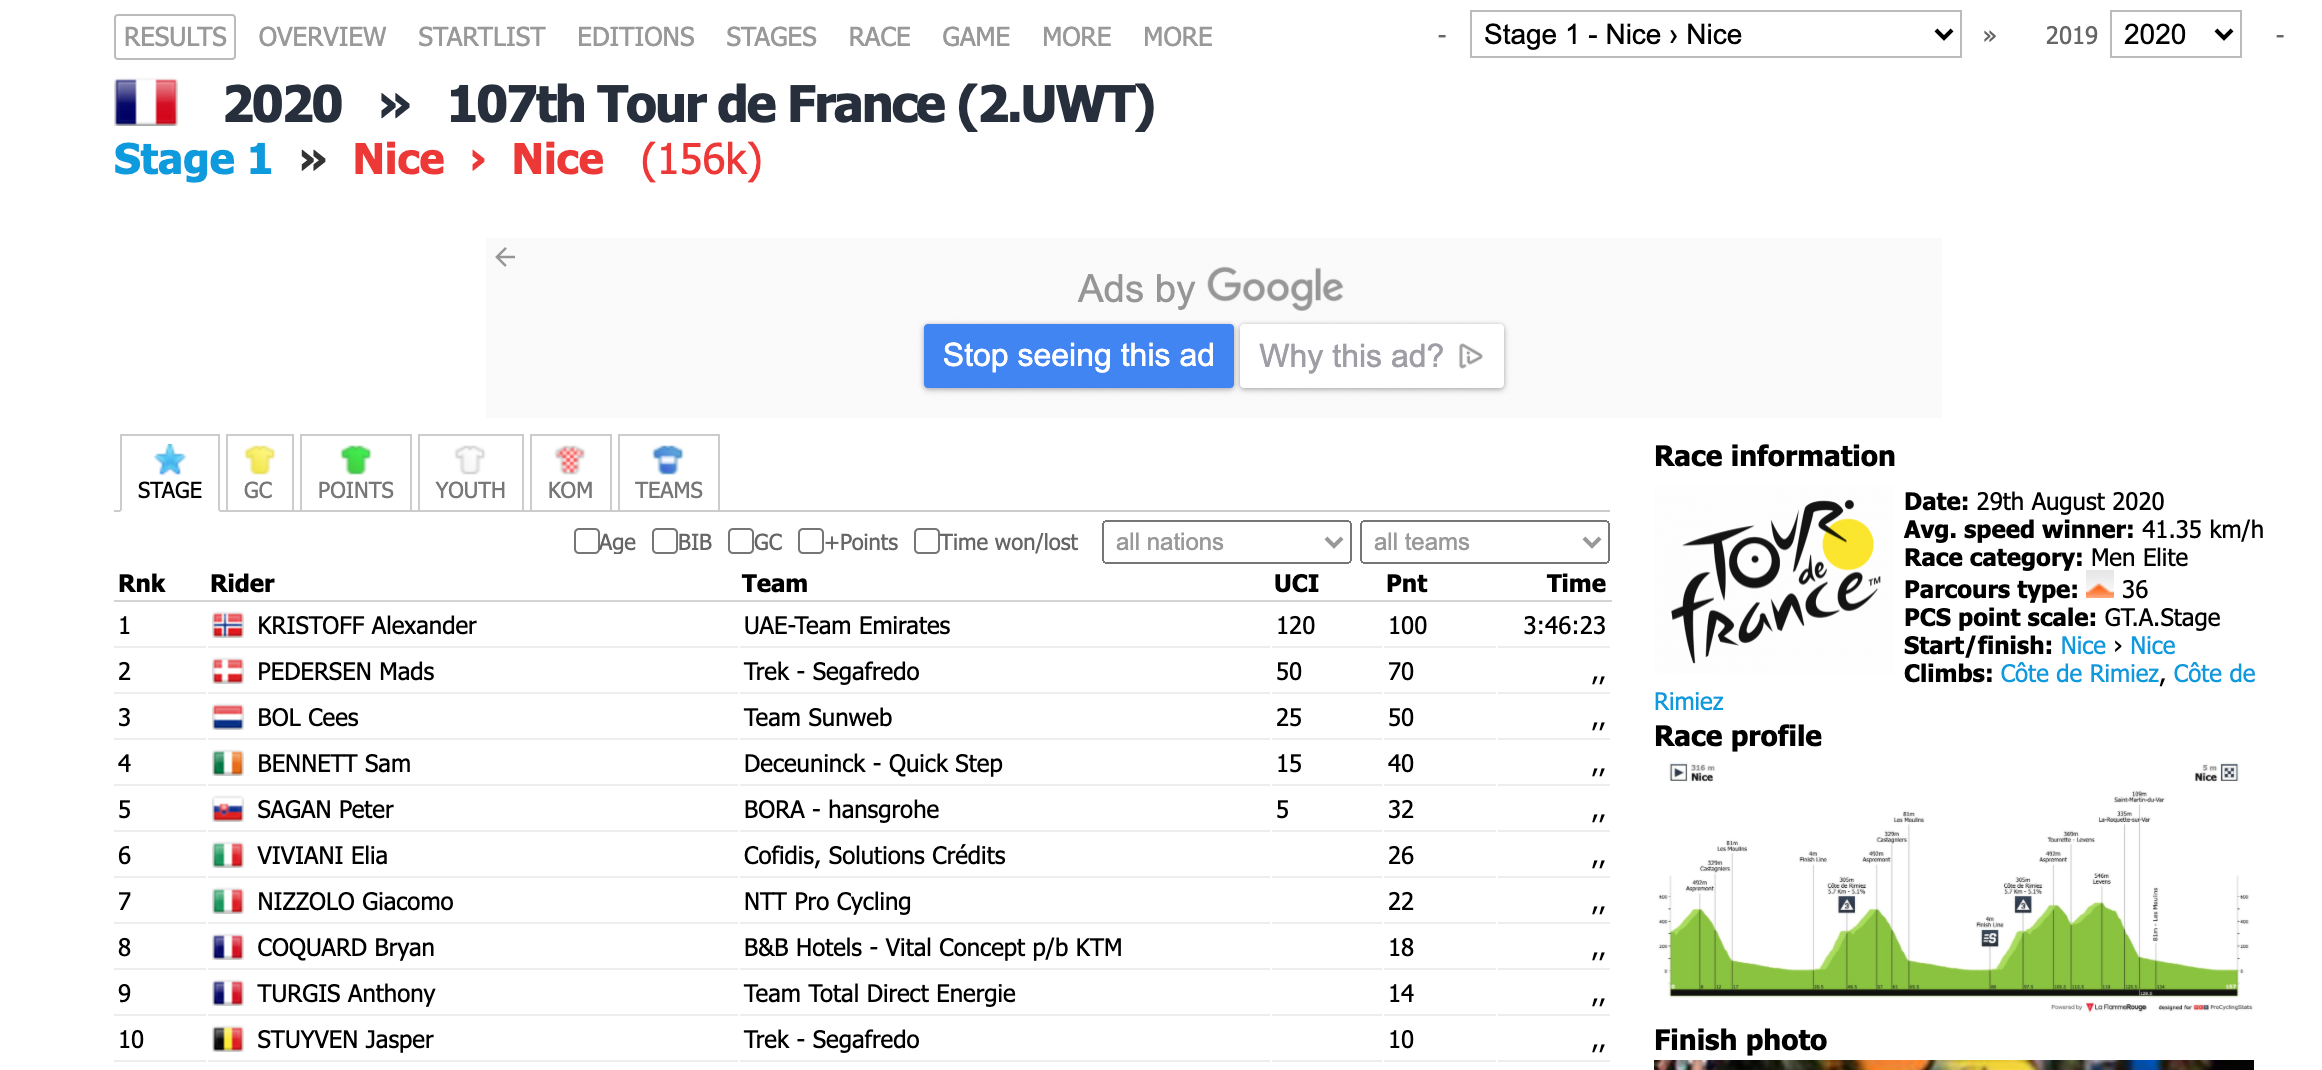

In [3]:
def get_stage_data(html, data_row_length, print_row=False):
    # all the racers are in a table data cell ('td')
    # intialise variables
    tdcs = html.find_all('td')
    # there can be up to 6 data tables on an html page
    #data = {'stage': list(), 'gc': list(), 'points': list(), 'youth': list(), 'kom': list(), 'teams': list()}
    data = {}
    print('Data row lengths:', data_row_length)
    datasets = list(data_row_length.keys())
    data_id = 0
    row_length = data_row_length[datasets[data_id]]
    
    old_length = row_length
    last_list_length = 0
    data_list = list()
    error_list = list()
    error_row = False
    
    row = list()
    last_ix = 1

    # itterate through all data cells and append their text values to a row
    for td_ix, cell in enumerate(tdcs):
        
        text = get_text(cell)
        if type(text) is type('str'):
            #print(row)
            row.append(text)
        else:
            row.append(text[0])
            row.append(text[1])
            
        if len(row) == 1:
            # the first element in the row is the position
            # if the rider did not finish, the position will not be an int
            # it will be: DNF, DNS, OTL
            not_int = is_not_int(row[0])
            
            if not_int:
                error_row = True
            
            if not not_int and int(row[0]) == 1 and len(data_list) != 0:
                # a new table begins with a rider being places 1st
                # save the complete previous table to the data map
                print('UPDATING 5: {} has {} participants'.format(datasets[data_id], len(data_list)))
                if datasets[data_id] == 'teams':
                    print('............................TEAMS')
                print('di', data_id)
                print('drl', datasets)
                ds_key = datasets[data_id]
                data[ds_key] = data_list

                old_length = row_length
                
                # reinitialise variables
                data_id += 1
                data_list = list()
                last_ix = 1
                error_row = False
                
                row_length = data_row_length[datasets[data_id]]
                if print_row:
                    print('OLD ROW: {}, NEW ROW: {}'.format(old_length, row_length))

        
        if error_row and len(row) == old_length:
            # a row with a DNS, DNF, OTL rider
            # put them in last position
            # append the disqualificationto the end of the row
            row.append(row[0])
            row[0] = last_ix
            print('ERROR: {}'.format(row))
            data_list.append(row)
            row = list()
            
        elif not error_row and len(row) == row_length:
            # 'row_length' data cells make an entire row
            if print_row:
                print(row)
            # data list gets saved in data subset
            pos = int(row[0])
            # DQ/ DNF/ OL column
            row.append(np.nan)
            data_list.append(row)
            last_ix = pos + 1
            row = list()
                
    print('UPDATING 1: {} has {} participants'.format(datasets[data_id], len(data_list)))
    ds_key = datasets[data_id]
    data[ds_key] = data_list
    return data

if CREATE_DATA:
    data_row_length = {'stage': 11, 'gc': 9, 'points': 8, 'youth': 9, 'kom': 8, 'teams': 4}
    data = get_stage_data(race_html, data_row_length)

In [4]:
try:
    stage_df = pd.DataFrame(data['stage'], columns=['stagePos', 'gcPos', 'timeAdd', 'bib', 'url', 'name', 'age', 'team', 'uciStg','stagePnt', 'stageTime', 'DNF'])
    print('Reading data.')
    stage_df = fix_time(stage_df, 'stageTime')
    stage_df = stage_df.set_index('bib')

    gc_df = pd.DataFrame(data['gc'], columns=['gcPos', 'bib', 'url', 'name', 'age', 'team', 'uciGc', 'time', 'more', 'DNF'])
    gc_df = gc_df[['bib', 'uciGc']].set_index('bib')

    
    green_df = pd.DataFrame(data['points'], columns=['greenPos', 'bib', 'url', 'name', 'age', 'team', 'greenPnts', 'pntsChng', 'DNF'])
    green_df = green_df[['bib', 'greenPos', 'greenPnts']].set_index('bib')

    youth_df = pd.DataFrame(data['youth'], columns=['youthPos', 'gcPos', 'timeAdd', 'bib', 'url', 'name', 'age', 'team', 'youthTime', 'DNF'])[['bib', 'youthPos', 'youthTime']]
    youth_df = fix_time(youth_df, 'youthTime')
    youth_df = youth_df.set_index('bib')

    kom_df = pd.DataFrame(data['kom'], columns=['komPos', 'bib', 'url', 'name', 'age', 'team', 'komPnts',  'pntsChnge', 'DNF'])
    kom_df = kom_df[['bib', 'komPos', 'komPnts']].set_index('bib')

    teams_df = pd.DataFrame(data['teams'], columns=['teamPos', 'change', 'teamName', 'teamTime', 'DNF'])
    teams_df = teams_df[['teamPos', 'teamName', 'teamTime']]

    df = pd.concat([stage_df, gc_df, green_df, youth_df, kom_df], axis=1, sort=False)
    df = df.reset_index().rename(columns={'index': 'bibNum'})
    df.to_csv(FIRST_STAGE_LOC)
except NameError:
    print('Reading data.')
    df = pd.read_csv(FIRST_STAGE_LOC, index_col='Unnamed: 0')

df.head()

Reading data.


,bibNum,stagePos,gcPos,timeAdd,url,name,age,team,uciStg,stagePnt,stageTime,DNF,uciGc,greenPos,greenPnts,youthPos,youthTime,komPos,komPnts
0,135,1,1.0,+0:00,rider/alexander-kristoff,Kristoff Alexander,33,UAE-Team Emirates,120.0,100.0,3:46:23,NaN,25.0,1.0,59.0,NaN,NaN,NaN,NaN
1,105,2,2.0,+0:04,rider/mads-pedersen,Pedersen Mads,24,Trek - Segafredo,50.0,70.0,3:46:23,NaN,NaN,2.0,30.0,1.0,3:46:17,NaN,NaN
2,203,3,3.0,+0:06,rider/cees-bol,Bol Cees,25,Team Sunweb,25.0,50.0,3:46:23,NaN,NaN,6.0,20.0,2.0,0:02,NaN,NaN
3,43,4,4.0,+0:10,rider/sam-bennett,Bennett Sam,29,Deceuninck - Quick Step,15.0,40.0,3:46:23,NaN,NaN,4.0,28.0,NaN,NaN,NaN,NaN
4,21,5,5.0,+0:10,rider/peter-sagan,Sagan Peter,30,BORA - hansgrohe,5.0,32.0,3:46:23,NaN,NaN,3.0,29.0,NaN,NaN,NaN,NaN


We have successfully scraped the html data for stage 1 of the tour. We have correctly extracted the 6 datasets and joined them into 1 dataframe, `df`, with only the important, non-repetative data columns present. 

In [5]:
print(df.DNF.unique())
# append a boolean feature column for cyclists that did not finish the stage
for finish_error in df.DNF.unique():
    if finish_error is not np.nan:
        df[finish_error] = 0

        df.loc[df.DNF == finish_error, [finish_error]] = 1

df['youth'] = 1
df.loc[df.youthTime.isnull(), ['youth']] = 0
# make the dataframe
df.name = df.name.str.upper()
df.team = df.team.str.upper()

print('There were {} cyclists that partook stage 1.\nThere is/ are {} that did not finish the stage.'.format(df.shape[0], df[(df.DNF != '') & (~df.DNF.isnull())].shape[0]))
df.head()

[nan 'OTL']
There were 176 cyclists that partook stage 1.
There is/ are 1 that did not finish the stage.


,bibNum,stagePos,gcPos,timeAdd,url,name,age,team,uciStg,stagePnt,...,DNF,uciGc,greenPos,greenPnts,youthPos,youthTime,komPos,komPnts,OTL,youth
0,135,1,1.0,+0:00,rider/alexander-kristoff,KRISTOFF ALEXANDER,33,UAE-TEAM EMIRATES,120.0,100.0,...,NaN,25.0,1.0,59.0,NaN,NaN,NaN,NaN,0,0
1,105,2,2.0,+0:04,rider/mads-pedersen,PEDERSEN MADS,24,TREK - SEGAFREDO,50.0,70.0,...,NaN,NaN,2.0,30.0,1.0,3:46:17,NaN,NaN,0,1
2,203,3,3.0,+0:06,rider/cees-bol,BOL CEES,25,TEAM SUNWEB,25.0,50.0,...,NaN,NaN,6.0,20.0,2.0,0:02,NaN,NaN,0,1
3,43,4,4.0,+0:10,rider/sam-bennett,BENNETT SAM,29,DECEUNINCK - QUICK STEP,15.0,40.0,...,NaN,NaN,4.0,28.0,NaN,NaN,NaN,NaN,0,0
4,21,5,5.0,+0:10,rider/peter-sagan,SAGAN PETER,30,BORA - HANSGROHE,5.0,32.0,...,NaN,NaN,3.0,29.0,NaN,NaN,NaN,NaN,0,0


## Create dataframes
We are going to separate the data frame above into 3 more succinct dataframes. 

- `riders_df` that contians the 175 riders' personal information.
- `stages_df` that contains that stages competed in by all the 175 riders in the past season (this will involve further scraping from the riders' personal profile pages).
- `races_df` that contains the information about the races that the 175 riders competed in in the past season (a race can have multiple stages)

In [6]:
if CREATE_DATA:
    riders_df = df[['name', 'age', 'url', 'team']]
    riders_df = riders_df.sort_values('name')
    riders_df['riderID'] = range(riders_df.shape[0])
    riders_df = riders_df.set_index('riderID')
    riders_df.to_csv(RIDERS_LOC)
else:
    riders_df = pd.read_csv(RIDERS_LOC, index_col='riderID')
riders_df.head()

,name,age,url,team
riderID,,,,
0,ALAPHILIPPE JULIAN,28,rider/julian-alaphilippe,DECEUNINCK - QUICK STEP
1,AMADOR ANDREY,34,rider/andrey-amador,INEOS GRENADIERS
2,ANACONA WINNER,32,rider/winner-anacona,TEAM ARKÉA SAMSIC
3,ARNDT NIKIAS,28,rider/nikias-arndt,TEAM SUNWEB
4,ARU FABIO,30,rider/fabio-aru,UAE-TEAM EMIRATES


In [7]:
def find_races(url, rider_id, rider_name):
    ''' Extract all the races in the season for each rider in the rider dfn the rider's profile (url)'''
    page = requests.get(url)
    rider_html = BeautifulSoup(page.content, 'html.parser')
    results_html = rider_html.body.tbody
    # all races in data rows (tr)
    rows = results_html.find_all('tr')

    races = list()
    for row in rows:
        items = row.find_all('td')
        # extract text values from data cell
        row = list()
        for item in items:
            text = get_text(item)
            if type(text) is type('str'):
                row.append(text)
            else:
                row.append(text[0])
                row.append(text[1])
        races.append(row)
    df = pd.DataFrame(races, columns=['date', 'stagePos', 'gcPos', 'unknown', 'url', 'stage', 'distance', 'pcs', 'uci', 'more'])
    print('"{}" competed in {} stages'.format(rider_name, df.shape[0]))
    df['riderID'] = rider_id
    return df

if CREATE_DATA:
    # initialise list of dataframes
    stages_list = list()
    # itterate through each cyclist and add their races for the season
    # to a list of dataframes
    for ix, row in riders_df.iterrows():
        print('{} of {}'.format(ix, riders_df.shape[0]))
        url = row['url']
        name = row['name']
        rider_url = 'https://www.procyclingstats.com/{}'.format(url)
        print(rider_url)
        riders_stages_df = find_races(rider_url, ix, name)
        stages_list.append(riders_stages_df)

In [8]:
if CREATE_DATA:
    stages_ = pd.concat(stages_list).reset_index(drop=True)
    print('{} stages have been loaded'.format(stages_.shape[0]))
    # drop 2 unnecessary columns
    stages_ = stages_.drop(['unknown', 'more'], axis=1)
    stages_.to_csv(STAGES_LOC)
else:
    stages_ = pd.read_csv(STAGES_LOC, index_col='Unnamed: 0')
    stages_.fillna('', inplace=True)
stages_.head()

,date,stagePos,gcPos,url,stage,distance,pcs,uci,riderID
0,› 20.09,,,race/tour-de-france/2020/stage-1,Tour de France,,,,0
1,10.09,11,38,race/tour-de-france/2020/stage-12,Stage 12 - Chauvigny › Sarran,218,8,,0
2,09.09,147,45,race/tour-de-france/2020/stage-11,Stage 11 - Châtelaillon-Plage › Poitiers,167.5,,,0
3,08.09,160,41,race/tour-de-france/2020/stage-10,Stage 10 - île d'Oléron (Le Château-d'Oléron) ...,168.5,,,0
4,06.09,160,38,race/tour-de-france/2020/stage-9,Stage 9 - Pau › Laruns,153,,,0


In [9]:
def _get_unique_races(data):
    '''
        Return a dataframe with the unique races with their information.
    '''
    data.columns = ['race', 'url']
    num_races = len(data.race.unique())
    num_url = len(data.url.unique())
    
    if num_races == num_url:
        rdf = data.groupby(['race', 'url']).count()
        rdf = rdf.reset_index()
        rdf['cutUrl'] = rdf.apply(lambda x: x['url'][0: x['url'].rindex('/')], axis =1)
        rdf.index.name = 'raceIX'
        return rdf
    else:
        return None
        
def _add_race_id_to_data(races_df, all_data):
    '''
        Append the race ID for each stage in the main df associated with the race. 
    '''
    if 'raceID' not in all_data.columns:
        print('Creating "raceID" collumn')
        all_data['raceID'] = np.nan
        
    for race_ix, race_row in races_df.iterrows():
        # for each race, put their id in the original. df
        url_begin = race_row['cutUrl']
        all_data.loc[all_data.url.str.startswith(url_begin), 'raceID'] = race_ix
        
    return all_data

def create_races_df(data):
    ''' 
    '''
    # multistage races 
    rdf = data[(data.distance == '') & (data.stagePos == '')][['stage', 'url']]
    rdf2 = _get_unique_races(rdf)
    data1 = _add_race_id_to_data(rdf2, data)
        
    # one day races
    odr = data1[data1.raceID.isnull()][['stage', 'url']]
    rdf3 = _get_unique_races(odr)
    data2 = _add_race_id_to_data(rdf3, data1)
    
    races_df = pd.concat([rdf2, rdf3], ignore_index=True)
    races_df['year'] = races_df.apply(lambda x: x['cutUrl'][x['cutUrl'].rindex('/') + 1:], axis =1)
    races_df.index.name = 'raceID'
    return races_df, data2
    
races_df, rhdf = create_races_df(stages_)
rhdf = rhdf.astype({'raceID': int})
print('There are {} unique races.\nThere are {} stages(s) without a raceID.'.format(races_df.shape[0], rhdf[rhdf.raceID.isnull()].shape[0]))
races_df.head()

Creating "raceID" collumn
There are 79 unique races.
There are 0 stages(s) without a raceID.


,race,url,cutUrl,year
raceID,,,,
0,Critérium du Dauphiné,race/dauphine/2020/stage-1,race/dauphine/2020,2020
1,Czech Tour,race/czech-cycling-tour/2020/stage-1,race/czech-cycling-tour/2020,2020
2,Etoile de Bessèges,race/etoile-de-besseges/2020/stage-1,race/etoile-de-besseges/2020,2020
3,Jayco Herald Sun Tour,race/herald-sun-tour/2020/stage-1,race/herald-sun-tour/2020,2020
4,La Route d'Occitanie - La Dépêche du Midi,race/la-route-d-occitanie/2020/stage-1,race/la-route-d-occitanie/2020,2020


In [10]:
print(rhdf.shape)
rhdf.head()

(7292, 10)


,date,stagePos,gcPos,url,stage,distance,pcs,uci,riderID,raceID
0,› 20.09,,,race/tour-de-france/2020/stage-1,Tour de France,,,,0,13
1,10.09,11,38,race/tour-de-france/2020/stage-12,Stage 12 - Chauvigny › Sarran,218,8,,0,13
2,09.09,147,45,race/tour-de-france/2020/stage-11,Stage 11 - Châtelaillon-Plage › Poitiers,167.5,,,0,13
3,08.09,160,41,race/tour-de-france/2020/stage-10,Stage 10 - île d'Oléron (Le Château-d'Oléron) ...,168.5,,,0,13
4,06.09,160,38,race/tour-de-france/2020/stage-9,Stage 9 - Pau › Laruns,153,,,0,13


In [11]:
# drop multi stage race heagings
rider_race_history_df = rhdf[(rhdf.distance != '') | (rhdf.stagePos != '')]
print(rider_race_history_df.shape)
# drop end of stage race classifcation
# will be added in more detail
rider_race_history_df = rider_race_history_df[(rider_race_history_df.date != '') | (rider_race_history_df.gcPos != '')]
print(rider_race_history_df.shape)
rider_race_history_df.head()

(6508, 10)
(5536, 10)


,date,stagePos,gcPos,url,stage,distance,pcs,uci,riderID,raceID
1,10.09,11,38,race/tour-de-france/2020/stage-12,Stage 12 - Chauvigny › Sarran,218,8,,0,13
2,09.09,147,45,race/tour-de-france/2020/stage-11,Stage 11 - Châtelaillon-Plage › Poitiers,167.5,,,0,13
3,08.09,160,41,race/tour-de-france/2020/stage-10,Stage 10 - île d'Oléron (Le Château-d'Oléron) ...,168.5,,,0,13
4,06.09,160,38,race/tour-de-france/2020/stage-9,Stage 9 - Pau › Laruns,153,,,0,13
5,05.09,38,26,race/tour-de-france/2020/stage-8,Stage 8 - Cazères › Loudenvielle,141,,,0,13


In [12]:
stgs_df = rider_race_history_df[['date', 'stage', 'url', 'distance']]
print(len(stgs_df.groupby(['date']).count()))
print(len(stgs_df.groupby(['stage']).count()))
print(len(stgs_df.groupby(['url']).count()))
stgs_df = stgs_df.groupby(['stage', 'url', 'date', 'distance']).count()
stgs_df = stgs_df.reset_index()
stgs_df.index.name = 'stagesID'

print(stgs_df.shape)
stgs_df.head()

93
193
193
(193, 4)


,stage,url,date,distance
stagesID,,,,
0,Bretagne Classic - Ouest-France,race/bretagne-classic/2020/result,25.08,247.75
1,Cadel Evans Great Ocean Road Race,race/great-ocean-race/2020/result,02.02,171.10
2,Circuito de Getxo-Memorial Hermanos Otxoa,race/circuito-de-getxo/2020/result,02.08,177.00
3,Clasica de Almeria,race/clasica-de-almeria/2020/result,16.02,187.60
4,European Continental Championships - ITT,race/uec-road-european-championships-itt/2020/...,24.08,25.60


In [13]:
stgs_df['cutUrl'] = stgs_df.apply(lambda x: x['url'][0: x['url'].rindex('/')], axis=1)
stgs_df['raceID'] = -1
for rix, race_row in races_df.iterrows():
    stgs_df.loc[stgs_df.cutUrl == race_row['cutUrl'], 'raceID'] = rix
print('{} stages have no raceID'.format(stgs_df[stgs_df.cutUrl == -1].shape[0]))
stgs_df.head()

0 stages have no raceID


,stage,url,date,distance,cutUrl,raceID
stagesID,,,,,,
0,Bretagne Classic - Ouest-France,race/bretagne-classic/2020/result,25.08,247.75,race/bretagne-classic/2020,27
1,Cadel Evans Great Ocean Road Race,race/great-ocean-race/2020/result,02.02,171.10,race/great-ocean-race/2020,28
2,Circuito de Getxo-Memorial Hermanos Otxoa,race/circuito-de-getxo/2020/result,02.08,177.00,race/circuito-de-getxo/2020,29
3,Clasica de Almeria,race/clasica-de-almeria/2020/result,16.02,187.60,race/clasica-de-almeria/2020,30
4,European Continental Championships - ITT,race/uec-road-european-championships-itt/2020/...,24.08,25.60,race/uec-road-european-championships-itt/2020,31


In [14]:
rider_race_history_df['stageID'] = np.nan

for stage_ix, stage_row in stgs_df.iterrows():
    stage_url = stage_row['url']
    rider_race_history_df.loc[rider_race_history_df.url == stage_url, 'stageID'] = stage_ix
    
print('{} races are unlabelled'.format(rider_race_history_df[rider_race_history_df.stageID.isnull()].shape[0]))
race_history_df = rider_race_history_df.drop(['url', 'stage', 'distance', 'date', 'raceID'], axis=1)
race_history_df = race_history_df.astype({'stageID': int})
race_history_df.head()

0 races are unlabelled


,stagePos,gcPos,pcs,uci,riderID,stageID
1,11,38,8,,0,77
2,147,45,,,0,76
3,160,41,,,0,75
4,160,38,,,0,187
5,38,26,,,0,185


After some cleaning and assigning columns to the correct dataframes, we have have the following 3 dataframes:

In [15]:
if CREATE_DATA:
    races_df.to_csv(RACES_LOC)
else:
    races_df = pd.read_csv(RACES_LOC, index_col='raceID')
races_df.head()

,race,url,cutUrl,year
raceID,,,,
0,Critérium du Dauphiné,race/dauphine/2020/stage-1,race/dauphine/2020,2020
1,Czech Tour,race/czech-cycling-tour/2020/stage-1,race/czech-cycling-tour/2020,2020
2,Etoile de Bessèges,race/etoile-de-besseges/2020/stage-1,race/etoile-de-besseges/2020,2020
3,Jayco Herald Sun Tour,race/herald-sun-tour/2020/stage-1,race/herald-sun-tour/2020,2020
4,La Route d'Occitanie - La Dépêche du Midi,race/la-route-d-occitanie/2020/stage-1,race/la-route-d-occitanie/2020,2020


In [16]:
riders_df.head()

,name,age,url,team
riderID,,,,
0,ALAPHILIPPE JULIAN,28,rider/julian-alaphilippe,DECEUNINCK - QUICK STEP
1,AMADOR ANDREY,34,rider/andrey-amador,INEOS GRENADIERS
2,ANACONA WINNER,32,rider/winner-anacona,TEAM ARKÉA SAMSIC
3,ARNDT NIKIAS,28,rider/nikias-arndt,TEAM SUNWEB
4,ARU FABIO,30,rider/fabio-aru,UAE-TEAM EMIRATES


In [17]:
stgs_df.head()

,stage,url,date,distance,cutUrl,raceID
stagesID,,,,,,
0,Bretagne Classic - Ouest-France,race/bretagne-classic/2020/result,25.08,247.75,race/bretagne-classic/2020,27
1,Cadel Evans Great Ocean Road Race,race/great-ocean-race/2020/result,02.02,171.10,race/great-ocean-race/2020,28
2,Circuito de Getxo-Memorial Hermanos Otxoa,race/circuito-de-getxo/2020/result,02.08,177.00,race/circuito-de-getxo/2020,29
3,Clasica de Almeria,race/clasica-de-almeria/2020/result,16.02,187.60,race/clasica-de-almeria/2020,30
4,European Continental Championships - ITT,race/uec-road-european-championships-itt/2020/...,24.08,25.60,race/uec-road-european-championships-itt/2020,31


We currently have subdivided this data from the riders' profiles and stage one. However, each race the rider partook in has its own profile and contains more detailed information about the stage:
- The positions and points of all the riders for each category
- The profile of the stage
- The UCI ranking of the stage

This data will be extracted below and appended to `stgs_df`. 

In [19]:
# get the points classifications
def get_points(stage_ID, stage_url, print_=False):
    ''' 
        Extract all the races in the season for the rider on the rider's profile (url)
    '''
    stg = stage.Stage(stage_ID, stage_url)
    stg.verify_datasets()
    stg.scrape_stage_data(print_=print_)
    print('DONE SCRAPING')
    stg.build_df()
    df = stg.get_all_df()
    df = df.reset_index()
    stgs_df.loc[stage_ID, 'stageType'] = stg.stage_type
    df.loc[:, 'stageType'] = stg.stage_type
    
    stg.find_stage_info()
    stage_info = stg.stage_info
    
    team_df = stg.team_df
    return df, stage_info, team_df

url_uniques = stgs_df.url.unique()
all_races = list()
all_stages = list()
all_teams = list()
written_1 = False
races_already = None
already_ids = None
all_df = None
most_columns = 0
try:
    races_already = pd.read_csv(ALL_RACE_DATA, index_col='Unnamed: 0')
    already_ids = races_already.stageID.unique()
    most_columns = len(races_already.columns)
except:
    stgs_df['stageType'] = 0
    print('No df')
    
reload_libraries()
for srix, srow in stgs_df.iterrows():
    url = srow['url']
    stage_id = srix
    if races_already is None or stage_id not in already_ids:
        print('\n\n')
        stage_url = 'https://www.procyclingstats.com/{}'.format(url)
        print('{} in {}: {}'.format(srix, len(url_uniques), url))
        rdf, stage_info_row, team_df = get_points(srix, stage_url, False)
        all_races.append(rdf)
        print('NEW STAGE INFO: ', stage_info_row)
        all_stages.append(stage_info_row)
        if len(stage_info_row) > 11:
            raise ValueError
        if team_df is not None:
            team_df['stageID'] = srix
            all_teams.append(team_df)

        if srix % 5 == 0 and srix > 0:
            all_df = pd.concat(all_races, axis=0, sort=False, ignore_index=True)
            if written_1 == False and races_already is None:
                all_df.to_csv(ALL_RACE_DATA)
                most_columns = len(all_df.columns)
            else:
                all_df.to_csv(ALL_RACE_DATA, mode='a', header=False)
                    
            written_1 = True
            all_races = list()
    else:
        print('{} with id {} already in csv'.format(url, stage_id))

if all_df is not None:
    all_df = pd.concat(all_races, axis=0, sort=False, ignore_index=True)
    all_df.to_csv(ALL_RACE_DATA, mode='a', header=False)

if len(all_stages) > 0:
    new_stg_info = pd.DataFrame(all_stages, columns=['dateFull', 'averageSpeed', 'raceCtgr', \
                                     'parcoursType', 'PCSPointScale', 'start',\
                                     'end', 'mountains', 'numMount', 'raceRank', \
                                     'racePoints'])
    stages_df  = pd.concat([stgs_df, new_stg_info], sort=False, axis=1)
    stages_df.to_csv(NEW_STAGES_LOC)

No df
Reloaded



0 in 193: race/bretagne-classic/2020/result
ONE DAY RACE
	UPDATING: stage has 159 participants
DONE SCRAPING
NEW STAGE INFO:  [' 25th August 2020', ' 41.15 km/h', ' Men Elite', '45', '1.WT.B', 'Plouay', 'Plouay', ['Restergal', 'Côte du Lezot', 'Restergal', 'Côte de Bon Repos', 'Mûr-de-Bretagne'], 5, '35', '390 pnt']



1 in 193: race/great-ocean-race/2020/result
ONE DAY RACE
	UPDATING: stage has 108 participants
DONE SCRAPING
NEW STAGE INFO:  [' 2nd February 2020', ' 41.76 km/h', ' Men Elite', '53', '1.WT.C', 'Geelong', 'Geelong', [], 0, '55', '395 pnt']



2 in 193: race/circuito-de-getxo/2020/result
ONE DAY RACE
	UPDATING: stage has 124 participants
DONE SCRAPING
NEW STAGE INFO:  [' 2nd August 2020', ' 42.29 km/h', ' Men Elite', '0*', '1.1', 'Getxo', 'Getxo', [], 0, '64', '238 pnt']



3 in 193: race/clasica-de-almeria/2020/result
ONE DAY RACE
	UPDATING: stage has 138 participants
DONE SCRAPING
NEW STAGE INFO:  [' 16th February 2020', ' 42.63 km/h', ' Men Elite', '0

ONE DAY RACE
	UPDATING: stage has 64 participants
DONE SCRAPING
NEW STAGE INFO:  [' 23rd August 2020', ' 42.17 km/h', ' Men Elite', '0*', 'Nationals.C3', 'Mamer', 'Mamer', [], 0, '182', '10 pnt']



33 in 193: race/nc-new-zealand-itt/2020/result
ITT (CC)/ (NC)
	UPDATING: stage has 14 participants
DONE SCRAPING
NEW STAGE INFO:  [' 14th February 2020', ' 49.91 km/h', ' Men Elite', '0*', 'Nationals.C3.TT', 'Cambridge', 'Cambridge', [], 0, '338', '10 pnt']



34 in 193: race/nc-new-zealand/2020/result
ONE DAY RACE
	UPDATING: stage has 80 participants
DONE SCRAPING
NEW STAGE INFO:  [' 16th February 2020', ' 40.99 km/h', ' Men Elite', '0*', 'Nationals.C3', 'Cambridge', 'Cambridge', [], 0, '307', '15 pnt']



35 in 193: race/nc-norway/2020/result
ONE DAY RACE
	UPDATING: stage has 151 participants
DONE SCRAPING
NEW STAGE INFO:  [' 23rd August 2020', ' 40.44 km/h', ' Men Elite', '0*', 'Nationals.C3', 'Vik', 'Royse', [], 0, '128', '33 pnt']



36 in 193: race/nc-slovenia-itt/2020/result
ITT (CC)

FIRST_STAGE_IN_TOUR
	UPDATING: stage has 139 participants
	UPDATING: gc has 136 participants
	UPDATING: youth has 49 participants
	UPDATING: kom has 11 participants
	UPDATING: teams has 20 participants
DONE SCRAPING
NEW STAGE INFO:  [' 18th August 2020', ' 40.7 km/h', ' Men Elite', '0*', '2.1.Stage', 'Couzeix', 'Evaux-Les-Bains', [], 0, '79', '151 pnt']



59 in 193: race/tour-de-langkawi/2020/stage-1
FIRST_STAGE_IN_TOUR
	UPDATING: stage has 123 participants
	UPDATING: gc has 123 participants
	UPDATING: points has 15 participants
	UPDATING: teams has 21 participants
DONE SCRAPING
NEW STAGE INFO:  [' 7th February 2020', ' 46.26 km/h', ' Men Elite', '0*', '2.HC.Stage', 'Kuching', 'Kuching', [], 0, '189', '65 pnt']



60 in 193: race/tour-du-haut-var/2020/stage-1
FIRST_STAGE_IN_TOUR
	UPDATING: stage has 123 participants
	UPDATING: gc has 118 participants
	UPDATING: points has 17 participants
	UPDATING: youth has 36 participants
	UPDATING: kom has 4 participants
	UPDATING: teams has 18 par

NEW STAGE INFO:  [' 8th September 2020', ' 46.94 km/h', ' Men Elite', '1', "île d'Oléron (Le Château-d'Oléron)", 'Île de Ré (Saint-Martin-de-Ré)', '2', ['1508 pnt'], 1]



76 in 193: race/tour-de-france/2020/stage-11
OTHER TOUR STAGE
	UPDATING: stage has 164 participants
gc (looking for prevGcPos, gcChng) text change (should be false) - True
gc (looking for gcPnt) text change (should be true)  46:15:24 True
	UPDATING: gc has 161 participants
ROW LENGTH IS: 11 and this is the row so far [76, '1', '1', '-']
This is the text (should be true): - False
	UPDATING: points has 110 participants
	UPDATING: youth has 25 participants
ROW LENGTH IS: 11 and this is the row so far [76, '1', '1', '-']
This is the text (should be true): - False
	UPDATING: kom has 43 participants
	UPDATING: teams has 22 participants
DONE SCRAPING
NEW STAGE INFO:  [' 9th September 2020', ' 41.62 km/h', ' Men Elite', '6', 'GT.A.Stage', 'Châtelaillon-Plage', 'Poitiers', ['Côte de Cherveux'], 1, '2', '1508 pnt']



77 in 19

OTHER TOUR STAGE
	UPDATING: stage has 140 participants
gc (looking for prevGcPos, gcChng) text change (should be false) ▲1 True
gc (looking for gcPnt) text change (should be true) 7:47:19 True
	UPDATING: gc has 138 participants
ROW LENGTH IS: 11 and this is the row so far [86, '1', '2', '▲1']
This is the text (should be true): ▲1 False
	UPDATING: points has 24 participants
	UPDATING: youth has 36 participants
	UPDATING: teams has 20 participants
DONE SCRAPING
NEW STAGE INFO:  [' 24th February 2020', ' 39.03 km/h', ' Men Elite', '78', '2.WT.C.Stage', 'Hatta', 'Hatta Dam', [], 0, '23', '751 pnt']



87 in 193: race/tour-de-langkawi/2020/stage-2
OTHER TOUR STAGE
	UPDATING: stage has 123 participants
gc (looking for prevGcPos, gcChng) text change (should be false) - True
gc (looking for gcPnt) text change (should be true) 5:56:14 True
	UPDATING: gc has 123 participants
ROW LENGTH IS: 11 and this is the row so far [87, '1', '1', '-']
This is the text (should be true): - False
	UPDATING: poi

OTHER TOUR STAGE
	UPDATING: stage has 120 participants
gc (looking for prevGcPos, gcChng) text change (should be false) - True
gc (looking for gcPnt) text change (should be true) 8:24:35 True
	UPDATING: gc has 117 participants
ROW LENGTH IS: 11 and this is the row so far [97, '1', '3', '▲2']
This is the text (should be true): ▲2 False
	UPDATING: points has 17 participants
	UPDATING: youth has 37 participants
	UPDATING: teams has 18 participants
DONE SCRAPING
NEW STAGE INFO:  [' 5th February 2020', ' 41.17 km/h', ' Men Elite', '0*', '2.1.Stage', 'Sadus Castle', 'Riyadh', [], 0, '128', '150 pnt']



98 in 193: race/volta-ao-algarve/2020/stage-2
OTHER TOUR STAGE
	UPDATING: stage has 172 participants
gc (looking for prevGcPos, gcChng) text change (should be false) ▲43 True
gc (looking for gcPnt) text change (should be true) 9:42:15 True
	UPDATING: gc has 171 participants
ROW LENGTH IS: 11 and this is the row so far [98, '1', '1', '-']
This is the text (should be true): - False
	UPDATING: p

OTHER TOUR STAGE
	UPDATING: stage has 89 participants
gc (looking for prevGcPos, gcChng) text change (should be false) - True
gc (looking for gcPnt) text change (should be true) 9:50:30 True
	UPDATING: gc has 80 participants
ROW LENGTH IS: 11 and this is the row so far [108, '1', '3', '▲2']
This is the text (should be true): ▲2 False
	UPDATING: points has 16 participants
	UPDATING: youth has 23 participants
ROW LENGTH IS: 11 and this is the row so far [108, '1', '1', '-']
This is the text (should be true): - False
	UPDATING: kom has 12 participants
	UPDATING: teams has 13 participants
DONE SCRAPING
NEW STAGE INFO:  [' 7th February 2020', ' 43.18 km/h', ' Men Elite', '0*', '2.1.Stage', 'Bright', 'Wangaratta', [], 0, '178', '83 pnt']



109 in 193: race/paris-nice/2020/stage-3
OTHER TOUR STAGE
	UPDATING: stage has 133 participants
gc (looking for prevGcPos, gcChng) text change (should be false) - True
gc (looking for gcPnt) text change (should be true)  13:12:01 True
	UPDATING: gc has 13

	UPDATING: kom has 19 participants
	UPDATING: teams has 21 participants
DONE SCRAPING
NEW STAGE INFO:  [' 8th August 2020', ' 39.51 km/h', ' Men Elite', '0*', '2.1.Stage', 'Olomouc', 'Frýdek-Místek', [], 0, '92', '110 pnt']



119 in 193: race/vuelta-a-la-comunidad-valenciana/2020/stage-3
OTHER TOUR STAGE
	UPDATING: stage has 142 participants
gc (looking for prevGcPos, gcChng) text change (should be false) ▲1 True
gc (looking for gcPnt) text change (should be true)  12:16:25 True
	UPDATING: gc has 141 participants
ROW LENGTH IS: 11 and this is the row so far [119, '1', '2', '▲1']
This is the text (should be true): ▲1 False
	UPDATING: points has 40 participants
	UPDATING: youth has 53 participants
ROW LENGTH IS: 11 and this is the row so far [119, '1', '1', '-']
This is the text (should be true): - False
	UPDATING: kom has 14 participants
	UPDATING: teams has 21 participants
DONE SCRAPING
NEW STAGE INFO:  [' 7th February 2020', ' 44.69 km/h', ' Men Elite', '0*', '2.HC.Stage', 'Orihuela'

	UPDATING: gc has 144 participants
ROW LENGTH IS: 11 and this is the row so far [129, '1', '3', '▲2']
This is the text (should be true): ▲2 False
	UPDATING: points has 44 participants
ROW LENGTH IS: 11 and this is the row so far [129, '1', '', '-']
This is the text (should be true): - False
	UPDATING: kom has 14 participants
	UPDATING: teams has 22 participants
DONE SCRAPING
NEW STAGE INFO:  [' 7th August 2020', ' 39.97 km/h', ' Men Elite', '100', '2.WT.Stage', 'Wadowice', 'Bielsko-Biała', ['Przełęcz Przegibek', 'Przełęcz Przegibek', 'Kocierz', 'Kocierz'], 4, '18', '648 pnt']



130 in 193: race/sibiu-cycling-tour/2020/stage-3a
(ITT)
	UPDATING: stage has 122 participants
gc (looking for prevGcPos, gcChng) text change (should be false) ▲1 True
gc (looking for gcPnt) text change (should be true) 9:21:06 True
	UPDATING: gc has 104 participants
	UPDATING: points has 43 participants
	UPDATING: youth has 29 participants
	UPDATING: kom has 18 participants
	UPDATING: teams has 21 participants


OTHER TOUR STAGE
	UPDATING: stage has 144 participants
gc (looking for prevGcPos, gcChng) text change (should be false) - True
gc (looking for gcPnt) text change (should be true)  15:26:35 True
	UPDATING: gc has 143 participants
ROW LENGTH IS: 11 and this is the row so far [140, '1', '12', '▲11']
This is the text (should be true): ▲11 False
	UPDATING: points has 41 participants
	UPDATING: youth has 64 participants
ROW LENGTH IS: 11 and this is the row so far [140, '1', '1', '-']
This is the text (should be true): - False
	UPDATING: kom has 30 participants
	UPDATING: teams has 22 participants
DONE SCRAPING
NEW STAGE INFO:  [' 31st July 2020', ' 42.28 km/h', ' Men Elite', '7', '2.HC.Stage', 'Gumiel de Izán', 'Roa de Duero', [], 0, '14', '697 pnt']



141 in 193: race/tour-du-limousin/2020/stage-4
OTHER TOUR STAGE
	UPDATING: stage has 126 participants
gc (looking for prevGcPos, gcChng) text change (should be false) rider/luca-wackermann False
gc (looking for gcPnt) text change (should be 

OTHER TOUR STAGE
	UPDATING: stage has 151 participants
gc (looking for prevGcPos, gcChng) text change (should be false) - True
gc (looking for gcPnt) text change (should be true)  17:45:32 True
	UPDATING: gc has 139 participants
ROW LENGTH IS: 11 and this is the row so far [151, '1', '1', '-']
This is the text (should be true): - False
	UPDATING: points has 34 participants
	UPDATING: youth has 24 participants
ROW LENGTH IS: 11 and this is the row so far [151, '1', '', '-']
This is the text (should be true): - False
	UPDATING: kom has 37 participants
	UPDATING: teams has 23 participants
DONE SCRAPING
NEW STAGE INFO:  [' 15th August 2020', ' 33.25 km/h', ' Men Elite', '257', '2.WT.Stage', 'Ugine', 'Megève', ['Montée de Bisanne', "Côte d'Héry-sur-Ugine", 'Col des Aravis', 'Col de la Croix Fry', 'Col de Plan Bois'], 5, '5', '1020 pnt']



152 in 193: race/ruta-del-sol/2020/stage-4
OTHER TOUR STAGE
	UPDATING: stage has 132 participants
gc (looking for prevGcPos, gcChng) text change (should 

OTHER TOUR STAGE
	UPDATING: stage has 135 participants
gc (looking for prevGcPos, gcChng) text change (should be false) ▲1 True
gc (looking for gcPnt) text change (should be true)  17:12:15 True
	UPDATING: gc has 133 participants
ROW LENGTH IS: 11 and this is the row so far [163, '1', '1', '-']
This is the text (should be true): - False
	UPDATING: points has 40 participants
	UPDATING: youth has 19 participants
ROW LENGTH IS: 11 and this is the row so far [163, '1', '1', '-']
This is the text (should be true): - False
	UPDATING: kom has 15 participants
	UPDATING: teams has 20 participants
DONE SCRAPING
NEW STAGE INFO:  [' 25th January 2020', ' 42.05 km/h', ' Men Elite', '46', '2.WT.Stage', 'Glenelg', 'Victor Harbor', [], 0, '41', '492 pnt']



164 in 193: race/tour-de-langkawi/2020/stage-5
OTHER TOUR STAGE
	UPDATING: stage has 117 participants
gc (looking for prevGcPos, gcChng) text change (should be false) - True
gc (looking for gcPnt) text change (should be true)  17:48:10 True
	UPDAT

OTHER TOUR STAGE
	UPDATING: stage has 172 participants
gc (looking for prevGcPos, gcChng) text change (should be false) - True
gc (looking for gcPnt) text change (should be true)  27:03:57 True
	UPDATING: gc has 172 participants
ROW LENGTH IS: 11 and this is the row so far [174, '1', '1', '-']
This is the text (should be true): - False
	UPDATING: points has 83 participants
	UPDATING: youth has 26 participants
ROW LENGTH IS: 11 and this is the row so far [174, '1', '1', '-']
This is the text (should be true): - False
	UPDATING: kom has 28 participants
	UPDATING: teams has 22 participants
DONE SCRAPING
NEW STAGE INFO:  [' 3rd September 2020', ' 42.04 km/h', ' Men Elite', '209', 'GT.A.Stage', 'Le Teil', 'Mont Aigoual', ['Col de la Lusette', 'Col des Mourèzes', 'Cap de Coste'], 3, '2', '1508 pnt']



175 in 193: race/tour-down-under/2020/stage-6
OTHER TOUR STAGE
	UPDATING: stage has 133 participants
gc (looking for prevGcPos, gcChng) text change (should be false) ▲1 True
gc (looking for gc

	UPDATING: gc has 155 participants
	UPDATING: youth has 16 participants
ROW LENGTH IS: 11 and this is the row so far [184, '1', '1', '-']
This is the text (should be true): - False
	UPDATING: kom has 23 participants
	UPDATING: teams has 27 participants
DONE SCRAPING
NEW STAGE INFO:  [' 2nd February 2020', ' 47.62 km/h', ' Men Elite', '0*', '2.HC.Stage', 'San Juan', 'San Juan', [], 0, '84', '262 pnt']



185 in 193: race/tour-de-france/2020/stage-8
OTHER TOUR STAGE
	UPDATING: stage has 172 participants
gc (looking for prevGcPos, gcChng) text change (should be false) - True
gc (looking for gcPnt) text change (should be true)  34:44:52 True
	UPDATING: gc has 168 participants
ROW LENGTH IS: 11 and this is the row so far [185, '1', '1', '-']
This is the text (should be true): - False
	UPDATING: points has 95 participants
ROW LENGTH IS: 11 and this is the row so far [185, '1', '33', 'rider/benoit-cosnefroy', ' Cosnefroy Benoît']
This is the text (should be true): rider/benoit-cosnefroy True


In [21]:
races_already = pd.read_csv(ALL_RACE_DATA, index_col='Unnamed: 0')
races_already.head()

,bib,DNF,age,avgTime,countryTeam,createBib,gcPnt,gcPos,gcTime,gcTotalTime,...,teamName,timeAdd,timeWonLost,uciGc,uciStage,url,youthGcTime,youthPos,youthTime,stageType
0,205,NaN,29.0,NaN,NaN,False,NaN,NaN,NaN,NaN,...,Team Sunweb,NaN,NaN,NaN,400.0,rider/michael-matthews,NaN,NaN,NaN,0
1,122,NaN,32.0,NaN,NaN,False,NaN,NaN,NaN,NaN,...,Mitchelton-Scott,NaN,NaN,NaN,320.0,rider/luka-mezgec,NaN,NaN,NaN,0
2,114,NaN,27.0,NaN,NaN,False,NaN,NaN,NaN,NaN,...,Deceuninck - Quick Step,NaN,NaN,NaN,260.0,rider/florian-senechal,NaN,NaN,NaN,0
3,222,NaN,26.0,NaN,NaN,False,NaN,NaN,NaN,NaN,...,Circus - Wanty Gobert,NaN,NaN,NaN,220.0,rider/aime-de-gendt,NaN,NaN,NaN,0
4,231,NaN,24.0,NaN,NaN,False,NaN,NaN,NaN,NaN,...,NIPPO DELKO One Provence,NaN,NaN,NaN,180.0,rider/alessandro-fedeli,NaN,NaN,NaN,0


In [22]:
stages_df = pd.read_csv(NEW_STAGES_LOC, index_col='Unnamed: 0')
print('{} == {}'.format(stages_df.shape[0], len(stages_df.index.unique())))
stages_df.head()

193 == 193


,stage,url,date,distance,cutUrl,raceID,stageType,dateFull,averageSpeed,raceCtgr,parcoursType,PCSPointScale,start,end,mountains,numMount,raceRank,racePoints
0,Bretagne Classic - Ouest-France,race/bretagne-classic/2020/result,25.08,247.75,race/bretagne-classic/2020,27,0,25th August 2020,41.15 km/h,Men Elite,45,1.WT.B,Plouay,Plouay,"['Restergal', 'Côte du Lezot', 'Restergal', 'C...",5.0,35.0,390 pnt
1,Cadel Evans Great Ocean Road Race,race/great-ocean-race/2020/result,2.02,171.10,race/great-ocean-race/2020,28,0,2nd February 2020,41.76 km/h,Men Elite,53,1.WT.C,Geelong,Geelong,[],0.0,55.0,395 pnt
2,Circuito de Getxo-Memorial Hermanos Otxoa,race/circuito-de-getxo/2020/result,2.08,177.00,race/circuito-de-getxo/2020,29,0,2nd August 2020,42.29 km/h,Men Elite,0*,1.1,Getxo,Getxo,[],0.0,64.0,238 pnt
3,Clasica de Almeria,race/clasica-de-almeria/2020/result,16.02,187.60,race/clasica-de-almeria/2020,30,0,16th February 2020,42.63 km/h,Men Elite,0*,1.HC,Roquetas de Mar,Roquetas de Mar,[],0.0,56.0,397 pnt
4,European Continental Championships - ITT,race/uec-road-european-championships-itt/2020/...,24.08,25.60,race/uec-road-european-championships-itt/2020,31,6,24th August 2020,50.69 km/h,Men Elite,0*,UCI.Cont.Ch.TT,Plouay,Plouay,[],0.0,104.0,86 pnt


In [25]:
stages_df[stages_df.numMount.isnull()]

,stage,url,date,distance,cutUrl,raceID,stageType,dateFull,averageSpeed,raceCtgr,parcoursType,PCSPointScale,start,end,mountains,numMount,raceRank,racePoints
9,Gran Trittico Lombardo,race/gran-trittico-lombardo/2020/result,3.08,199.7,race/gran-trittico-lombardo/2020,36,0,3rd August 2020,42.64 km/h,Men Elite,77,1.HC,Legnano,Varese,NaN,NaN,NaN,NaN
68,Stage 1 - Saint-Affrique › Cazouls-lès-Béziers,race/la-route-d-occitanie/2020/stage-1,1.08,189.5,race/la-route-d-occitanie/2020,4,1,1st August 2020,41.35 km/h,Men Elite,0*,2.1.Stage,Saint-Affrique,Cazouls-lès-Béziers,NaN,NaN,NaN,NaN
82,Stage 2 - Carcassonne › Cap Découverte,race/la-route-d-occitanie/2020/stage-2,2.08,182.5,race/la-route-d-occitanie/2020,4,2,2nd August 2020,41.73 km/h,Men Elite,32,2.1.Stage,Carcassonne,Cap Découverte,NaN,NaN,NaN,NaN
122,Stage 3 - Saint-Gaudens › Col de Beyrède,race/la-route-d-occitanie/2020/stage-3,3.08,163.5,race/la-route-d-occitanie/2020,4,2,3rd August 2020,35.45 km/h,Men Elite,299,2.1.Stage,Saint-Gaudens,Col de Beyrède,NaN,NaN,NaN,NaN
143,Stage 4 - Lectoure › Rocamadour,race/la-route-d-occitanie/2020/stage-4,4.08,195.0,race/la-route-d-occitanie/2020,4,2,4th August 2020,44.41 km/h,Men Elite,67,2.1.Stage,Lectoure,Rocamadour,NaN,NaN,NaN,NaN
188,Strade Bianche,race/strade-bianche/2020/result,1.08,184.0,race/strade-bianche/2020,74,0,1st August 2020,36.93 km/h,Men Elite,104,1.WT.C,Siena,Siena,NaN,NaN,NaN,NaN


In [27]:
stages_df.loc[stages_df.numMount.isnull(), 'mountains'] = '[]'
stages_df.loc[stages_df.numMount.isnull(), 'numMount'] = 0
stages_df.loc[stages_df.numMount.isnull(), 'racePoints'] = 0
stages_df.to_csv(NEW_STAGES_LOC)

In [28]:
if CREATE_DATA:
    teams_df = pd.concat(all_teams, axis=0, sort=False, ignore_index=True)
    teams_df.drop(['DNF', 'empty'], axis=1, inplace=True)
    teams_df.to_csv(TEAMS_HISTORY_LOC)
else:
    teams_df = pd.read_csv(TEAMS_HISTORY_LOC, index_col = 'Unnamed: 0')
print(teams_df.shape)
teams_df.head()

(957, 4)


,teamPos,teamName,teamTime,stageID
0,1,Team Arkéa Samsic,52:07:18,141
1,2,Groupama - FDJ,1:01,141
2,3,Team Sunweb,3:52,141
3,4,Caja Rural - Seguros RGA,5:00,141
4,5,"Cofidis, Solutions Crédits",7:41,141
